In [1]:
# ML-Agents
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

# Reinforce Lab & plots
from q_learning import QLearningAgent
from plots import plot_performance, plot_state_values, plot_frequencies

# Imports
import numpy as np
from tqdm import tqdm

In [2]:
# Environment
channel = EngineConfigurationChannel()
unity_env = UnityEnvironment(file_name = 'app/Windows/Factored-Workshop-2D.exe', seed=0, side_channels=[channel])

# Set Speed
channel.set_configuration_parameters(time_scale = 20)

env = UnityToGymWrapper(
    unity_env=unity_env,
    flatten_branched=False, 
    allow_multiple_obs=False ,
    action_space_seed=None
    )

[WARNING] The environment contains multiple observations. You must define allow_multiple_obs=True to receive them all. Otherwise, only the first visual observation (or vector observation ifthere are no visual observations) will be provided in the observation.


In [3]:
# Let's transform coordinates to a natural number.
cord_to_idx = {}
idx = 0

for x in range(-2, 12):
    for y in range(0, 9):
        cord_to_idx[(x,y)] = idx
        idx += 1

# Set Environment Attribute
env.custom_observation_space_dict = cord_to_idx

# Get inverse map
idx_to_cord = {v: k for k, v in cord_to_idx.items()}

In [4]:
# Train function
def train(env, agent, path, num_epochs=1_000, epsilon=0.5, epsilon_decay=4e-6, min_epsilon=.01):
    loop = tqdm(range(num_epochs))
    best_avg_reward = float("-inf")
    rewards_history = []
    state_history = []

    for _ in loop:
        state = env.reset()
        
        # Transform (x,y)->idx
        state = cord_to_idx[tuple(state[:2])]
        state_history.append(state)

        epoch_cum_reward = 0
        while True:
            # Generate a RL interaction
            action = agent.act(state, epsilon=epsilon)
            next_state, reward, done, info = env.step(action)

            # Transform (x,y,z)->idx
            next_state = cord_to_idx[tuple(next_state[:2])]
            state_history.append(next_state)
            
            agent.update(state, action, reward, next_state, done)

            # Update epsilon
            epsilon = max(min_epsilon, epsilon * (1 - epsilon_decay))

            epoch_cum_reward += reward
            state = next_state

            if done:
                break

        # Show performance
        rewards_history.append(epoch_cum_reward)
        rewards_window = rewards_history[-100:]
        avg_reward = sum(rewards_window)/len(rewards_window)

        # Save best model
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            agent.save(path)

        loop.set_description(
            f"Avg 100eps Reward: {round(avg_reward, 4)} | Epsilon: {round(epsilon, 3)}")
    return rewards_history, state_history

# Test Function
def test(env, agent, num_episodes=100):
    cum_reward = 0
    rewards_history = []
    state_history = []

    for _ in tqdm(range(num_episodes)):
        state = env.reset()

        # Transform (x,y)->idx
        state = cord_to_idx[tuple(state[:2])]
        state_history.append(state)

        ep_cum_reward = 0
        while True:
            action = agent.act(state, epsilon=0)
            next_state, reward, done, info = env.step(action)
            ep_cum_reward += reward

            # Transform (x,y)->idx
            state = cord_to_idx[tuple(next_state[:2])]
            state_history.append(state)

            if done:
                break

        cum_reward += ep_cum_reward
        rewards_history.append(ep_cum_reward)

    avg_reward = cum_reward / num_episodes
    env.close()
    print(f"The agent obtained an average reward of {round(avg_reward, 4)} over {num_episodes} episode(s)")
    return rewards_history, state_history


# Train Agent
agent = QLearningAgent(env, gamma=0.9999, alpha=0.10)
path = "factored-workshop-agent"

rewards_history, state_history = train(env, agent, path, num_epochs=500, epsilon=0.2, epsilon_decay=1e-4, min_epsilon=.05)
agent.load(path)
training_rewards_history, training_state_history = test(env, agent)

Avg 100eps Reward: 0.905 | Epsilon: 0.05: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]   
100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


The agent obtained an average reward of 1.0 over 100 episode(s)


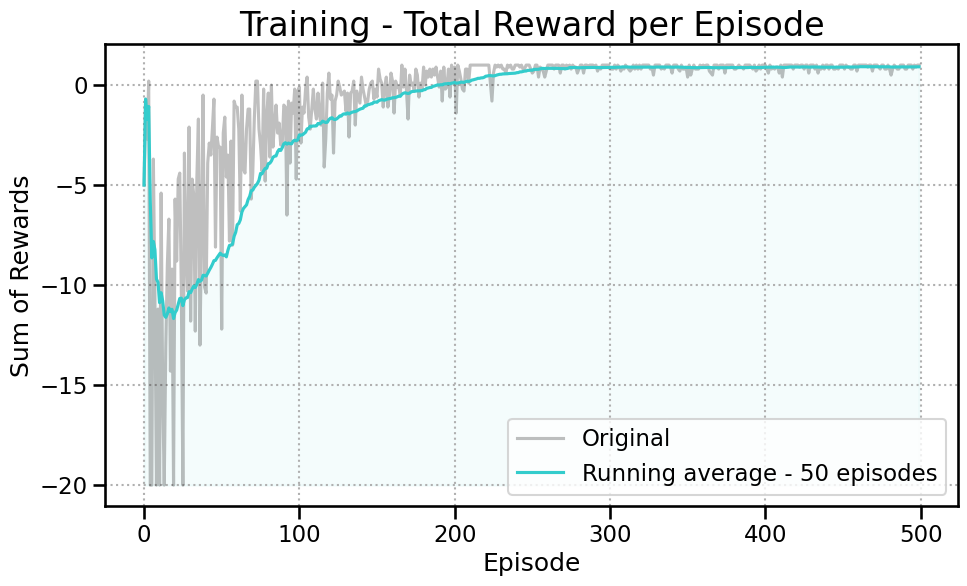

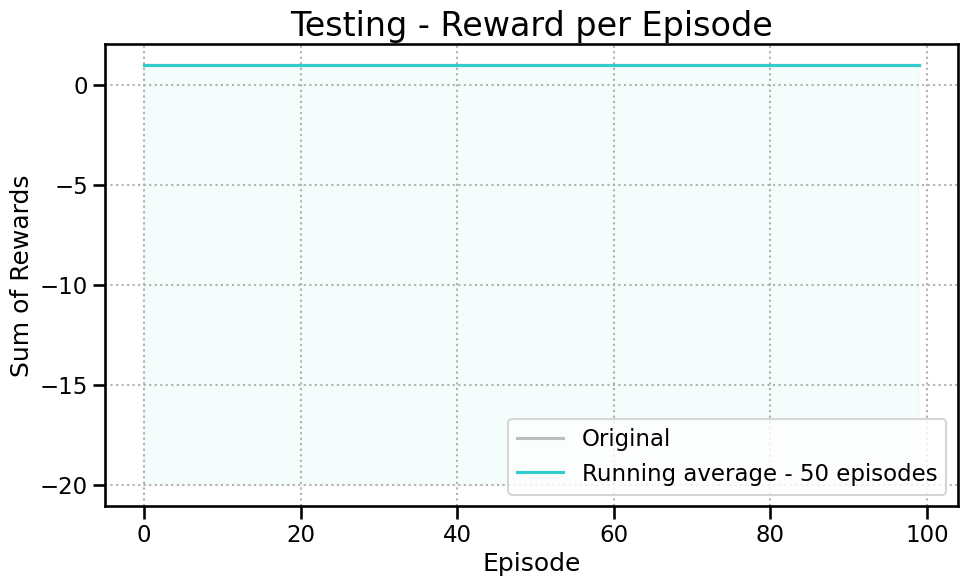

In [5]:
# Performance Plots
plot_performance(rewards_history, title='Training - Total Reward per Episode')
plot_performance(training_rewards_history, title='Testing - Reward per Episode' )

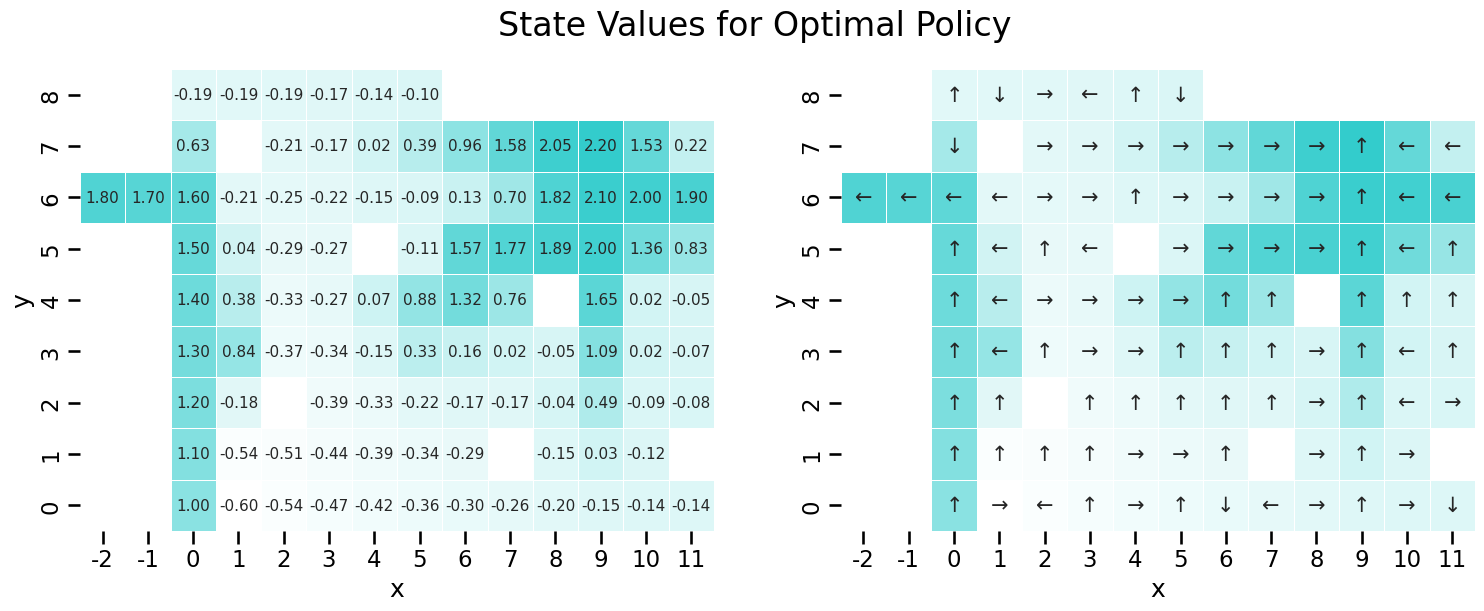

In [6]:
# State Values
plot_state_values(agent.qtable, idx_to_cord)

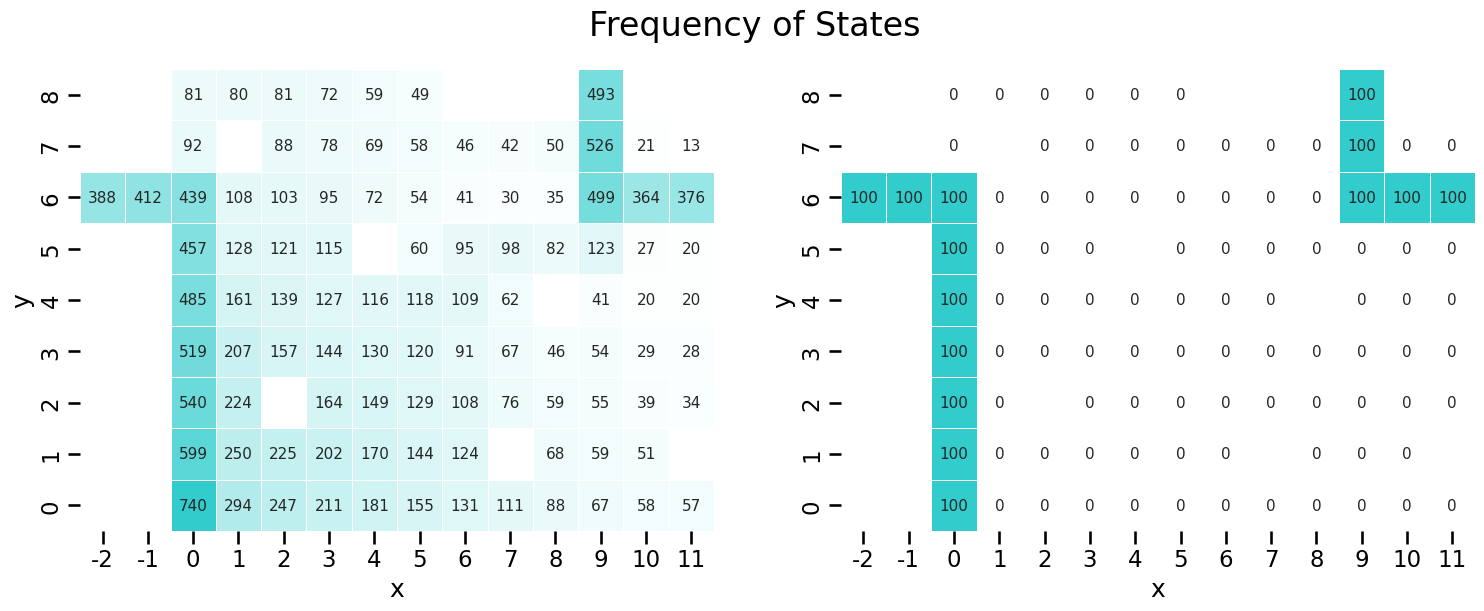

In [7]:
# State Frequencies
plot_frequencies(state_history, training_state_history, idx_to_cord)

Factored 2023 - Reinforcement Learning & Unity Workshop ©